# Download data

In [17]:
import os
import zipfile
import kaggle
# use kaggle api to download the data or manully download the data urself
## ! Kaggle competitions download -c "jane-street-real-time-market-data-forecasting" 

# make the directory to be "data/jane-street-real-time-market-data-forecasting" and extract file there u f the code dont work do it manually
## os.makedirs("data/jane-street-real-time-market-data-forecasting", exist_ok=True) # create directory for jane-street-real-time-market-data-forecasting-housing
## !unzip jane-street-real-time-market-data-forecasting.zip -d data/jane-street-real-time-market-data-forecasting/

# Kaggle Competition 

In [18]:
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [20]:
# function for import the data .parquet to pandas dataframe
def import_data(i): # the data have 10 partiton 0 to 9
    file_path = f"data/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet"
    df = pd.read_parquet(file_path)
    print(f"import train data part {i}")
    return df

In [5]:
# test/example of the import fuction
# train0 = download_data(0)
train_data = import_data(9) # there are just more data in the train.parquet partition 9

import train data part 9


In [21]:
# import test data 
file_path  = f"data/jane-street-real-time-market-data-forecasting/test.parquet/date_id=0/part-0.parquet"
test_data = pd.read_parquet(file_path)

In [40]:
# import lag data
file_path  = f"data/jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet"
lag_data = pd.read_parquet(file_path)

# Data Preprocessing

## Data cleaning

In [23]:
# feature selection ## select every feature except 0-4 
feature_cols = [f"feature_{idx:02d}" for idx in range(79)]

#select target values
target_cols = ["responder_6"]

#select lag values
time_cols = ["date_id","time_id"]

# select the weight values
weight_cols = ["weight"]

## drop the other responder column

## respons to nan values

In [24]:
# remove the nan values
def replace_nan_with_mean_or_zero(column):
    mean_value = column.mean()
    if pd.notnull(mean_value):
        return column.fillna(mean_value)
    else:
        return column.fillna(0)

# try to create the final data with lag from sample

In [25]:
group_by = ["date_id", "symbol_id"]
lag_col = ["responder_6_lag_1"]
result = pd.merge(test_data, lag_data, on = group_by)
X_test = result[feature_cols + lag_col]
X_test = X_test.apply(replace_nan_with_mean_or_zero)

In [42]:
train_data.groupby('symbol_id')[target_cols].shift(1)

,responder_6
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
6274571,-0.097485
6274572,-0.287828
6274573,0.249421
6274574,0.014149


# Create training data with lag

In [31]:
# Extract features and target, and add lagged target values
train_data['responder_6_lag_1'] = train_data.groupby('symbol_id')[target_cols].shift(1)
train_data = train_data.apply(replace_nan_with_mean_or_zero)
all_features_cols= feature_cols + ['responder_6_lag_1']

In [45]:
train_data.loc[train_data.symbol_id == 1].head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,responder_6_lag_1
1,1530,0,1,2.232906,0.553354,1.730064,0.990195,0.611490,2.023031,0.319015,...,-0.318671,-0.399384,-0.635306,2.092151,0.342582,0.757289,1.979042,0.967537,1.219739,-0.003780
38,1530,1,1,2.232906,0.679161,2.182005,0.564393,0.949822,2.086140,0.267718,...,0.340812,-0.153341,0.077146,1.525227,0.565891,1.458438,1.806185,0.891423,1.720961,1.979042
75,1530,2,1,2.232906,1.127959,1.818981,0.769063,0.970389,2.096153,0.588529,...,0.133512,-0.202637,0.209001,1.815752,0.670234,0.898668,1.809553,0.831876,1.617877,1.806185
112,1530,3,1,2.232906,1.064403,2.024062,0.425196,0.540093,2.282700,0.607599,...,-0.534442,-0.530471,-0.595954,1.103941,0.547151,0.734946,1.838943,0.659900,1.501268,1.809553
149,1530,4,1,2.232906,0.587649,2.165441,0.379769,0.195409,2.437657,0.141732,...,0.508943,-0.326350,0.151312,1.736283,0.785355,1.353318,1.783804,0.685266,2.356965,1.838943


In [32]:
# Split the data into training and validation sets
max_date_id = train_data['date_id'].max()
num_val = 10
train_set = train_data[train_data['date_id'] < max_date_id - num_val]
val_set = train_data[train_data['date_id'] >= max_date_id - num_val]

# model

In [21]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train = train_set[all_features_cols]
y_train = train_set[target_cols]
pipeline = make_pipeline(StandardScaler(), SGDRegressor())

# Fit the model
pipeline.fit(X_train, y_train)

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [26]:
pred = pipeline.predict(val_set[all_features_cols])
r2_score(val_set[target_cols], pred, sample_weight=val_set[weight_cols])

0.8222057239251578

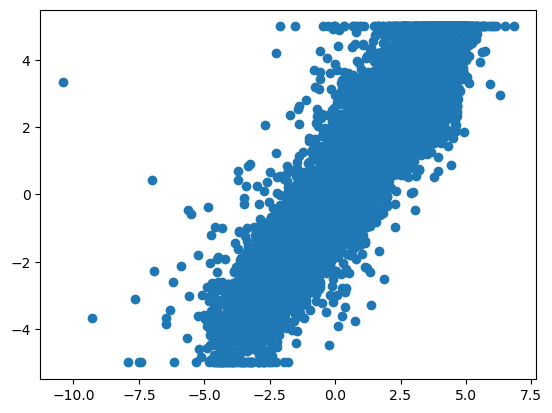

In [27]:
import matplotlib.pyplot as plt
plt.scatter(x = pred, y = val_set[target_cols])

In [14]:
def validate_n_fold(model, val_set, features, target,n_fold):
    batch_size = len(val_set)//n_fold
    for i in range(0, len(val_set), batch_size):
        val_batch = val_set.iloc[i:i+batch_size]
        preds = model.predict(val_batch[features])
        score1 = r2_score(val_batch[target_cols], preds ,sample_weight= val_batch[weight_cols])
        print(f'Batch {i//batch_size} r2_score: {score1:.4f}')

In [28]:
validate_n_fold(pipeline, val_set, all_features_cols, target_cols, 10)

Batch 0 r2_score: 0.8227
Batch 1 r2_score: 0.8217
Batch 2 r2_score: 0.8229
Batch 3 r2_score: 0.8348
Batch 4 r2_score: 0.8071
Batch 5 r2_score: -3.6917


In [ ]:
# try to predict acutal test data

In [33]:
import joblib
# save
joblib.dump(pipeline, "SDGReg.pkl") 

NameError: name 'pipeline' is not defined

In [38]:
model = joblib.load("SDGReg.pkl")
validate_n_fold(model, val_set, all_features_cols, target_cols, 10)

Batch 0 r2_score: 0.8183
Batch 1 r2_score: 0.8262
Batch 2 r2_score: 0.8091
Batch 3 r2_score: 0.8341
Batch 4 r2_score: 0.8258
Batch 5 r2_score: 0.8191
Batch 6 r2_score: 0.8303
Batch 7 r2_score: 0.8382
Batch 8 r2_score: 0.7979
Batch 9 r2_score: 0.8175
Batch 10 r2_score: -3.6917
